# GAIA Clustering and Get ilabel
#### -------------------------------------------------------------------------
## Data importation from **.vot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.cluster import DBSCAN
from sklearn import cluster

import sys, os
sys.path.append('C:\\Users\Quentin\\Documents\\ALMA_CHILI\\gaia-shock\\src')

## directory
rootdir = r'C:\Users\Quentin\Documents\ALMA_CHILI'
wdir    = r'%s\products'%(rootdir)
#notedir = r'%s\gaia-shock\notebooks_Quentin'%(rootdir)

os.chdir(wdir)  # to change the current directory

import gaia_utils_quentin as gu

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
voname_list = ["NGC2682-4.0deg-0.2err.vot", "NGC2516-3.5deg-0.2err.vot","NGC6811-1.0deg-0.2err.vot", "NGC1039-3.0deg-0.1err.vot",
               "Collinder65-4.0deg-0.2err.vot", "NGC1647-3.0deg-0.1err.vot"]

voname  = voname_list[2]
weight  = [5,1,1,4,4,4,4,4]
WEIGHT  = [10.7, 6.5, 6.5, 4.1, 4.1, 2.1, 2.1, 2.1]

In [3]:
source = gu.source()
source.read_votable(voname)
source.convert_filter_data()
source.convert_to_cartesian()
source.set_weight(weight)
source.normalization_normal()

## NGC6811-1.0deg-0.2err.vot read...
## Total stars: 12084
## Density star per pc^3: 0.00925

## Conversion done...
## Stars selected: 11886
## Normalization done on filtered data..


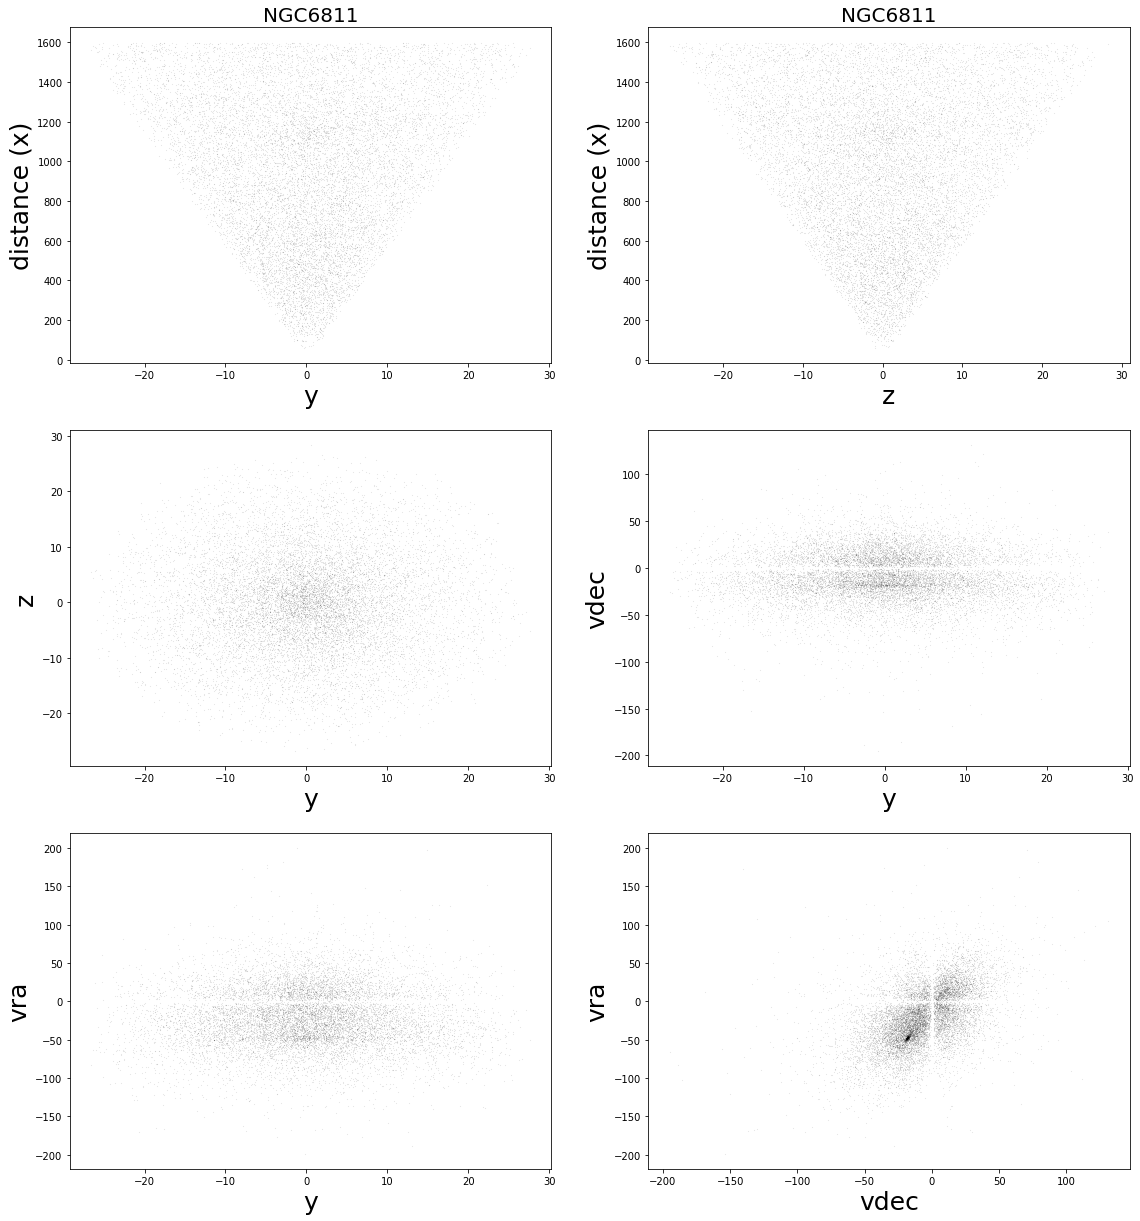

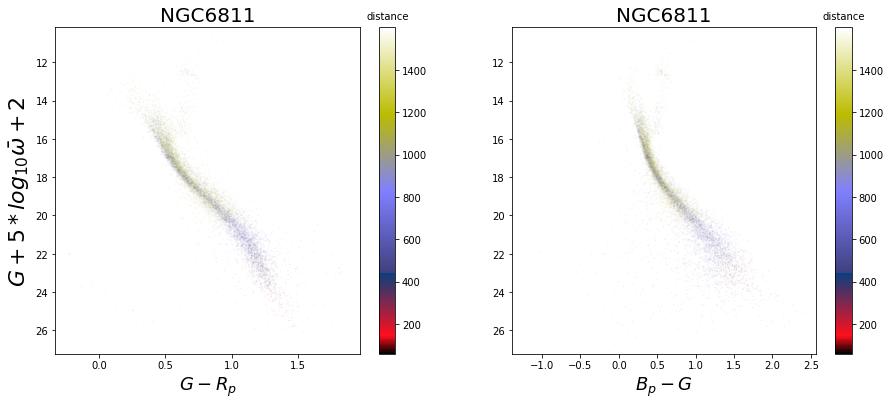

In [4]:
source.plot_information(0.001,True)

#### -------------------------------------------------------------------------

In [5]:
def save_ilabel(clustername, ilabel, eps, min_samples, weight, density) :
    "Save ilabel found with dbscan(eps,min_samples,weight) from cluster 'clustername'"
    
    with open('ilabel_dbscan', 'rb') as fichier:
        my_depickler = pickle.Unpickler(fichier)
        file_result = my_depickler.load()

    if clustername not in file_result :
        file_result[clustername] = {}

    file_result[clustername] = {}
    file_result[clustername]['eps_min_samples'] = (eps,min_samples)
    file_result[clustername]['weight'] = weight
    file_result[clustername]['ilabel'] = ilabel
    file_result[clustername]['density'] = density

    with open('ilabel_dbscan', 'wb') as fichier:
        my_pickler = pickle.Pickler(fichier)
        my_pickler.dump(file_result)

#### -------------------------------------------------------------------------
## DBSCAN Clustering

In [22]:
print(source.density)
print(source.distmax)
print(np.tan(np.pi*0.2/180)*1250*2)

0.009246539163145912
1600.0
8.726681703990625


In [33]:
weight  = [6*2000/source.distmax,2,2,4,4,4,4,4]
WEIGHT  = [10.7, 6.5, 6.5, 4.1, 4.1, 2.1, 2.1, 2.1]
source.set_weight(weight)
source.normalization_normal()
print(2000/source.distmax)

## Normalization done on filtered data..
1.25


In [56]:
a = np.arange(5)
np.concatenate(a,a)

TypeError: only integer scalar arrays can be converted to a scalar index

In [57]:
eps=2.0
min_samples=20
ilabel_ = source.dbscan_labels(eps, min_samples, all_labels=True, display=True)
ilabel = np.concatenate((ilabel_[0],ilabel_[1]), axis=0)
ilabel_ = [ilabel]
#save_ilabel(source.name, ilabel, eps, min_samples, weight, source.density)

## 2 clusters, size of the largest: 323  (on 11886 stars : 2.7%)
## Execution time : 0.7s


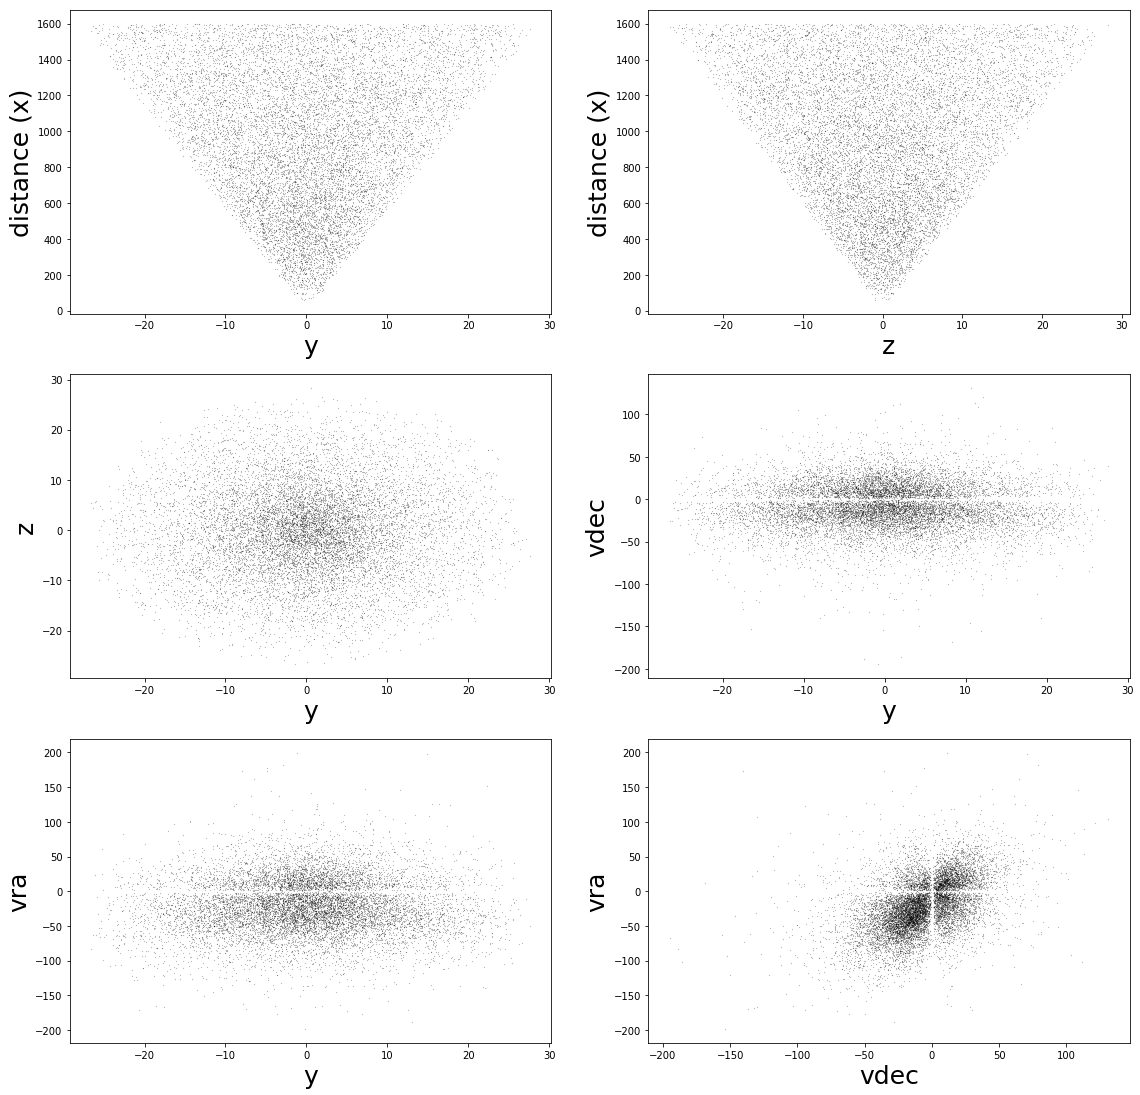

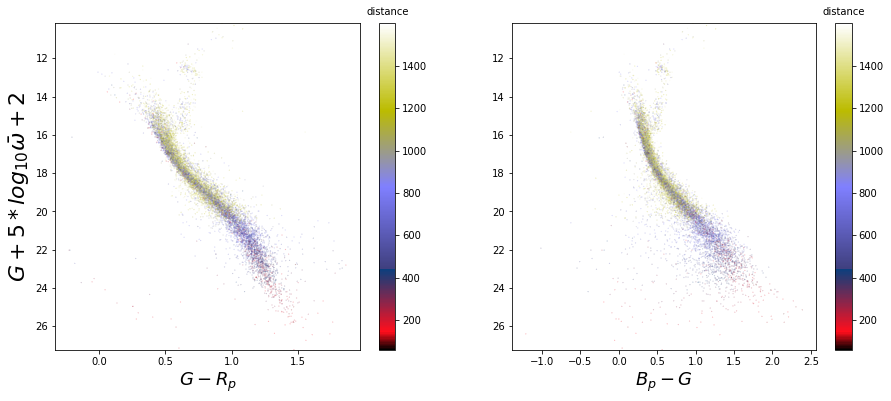

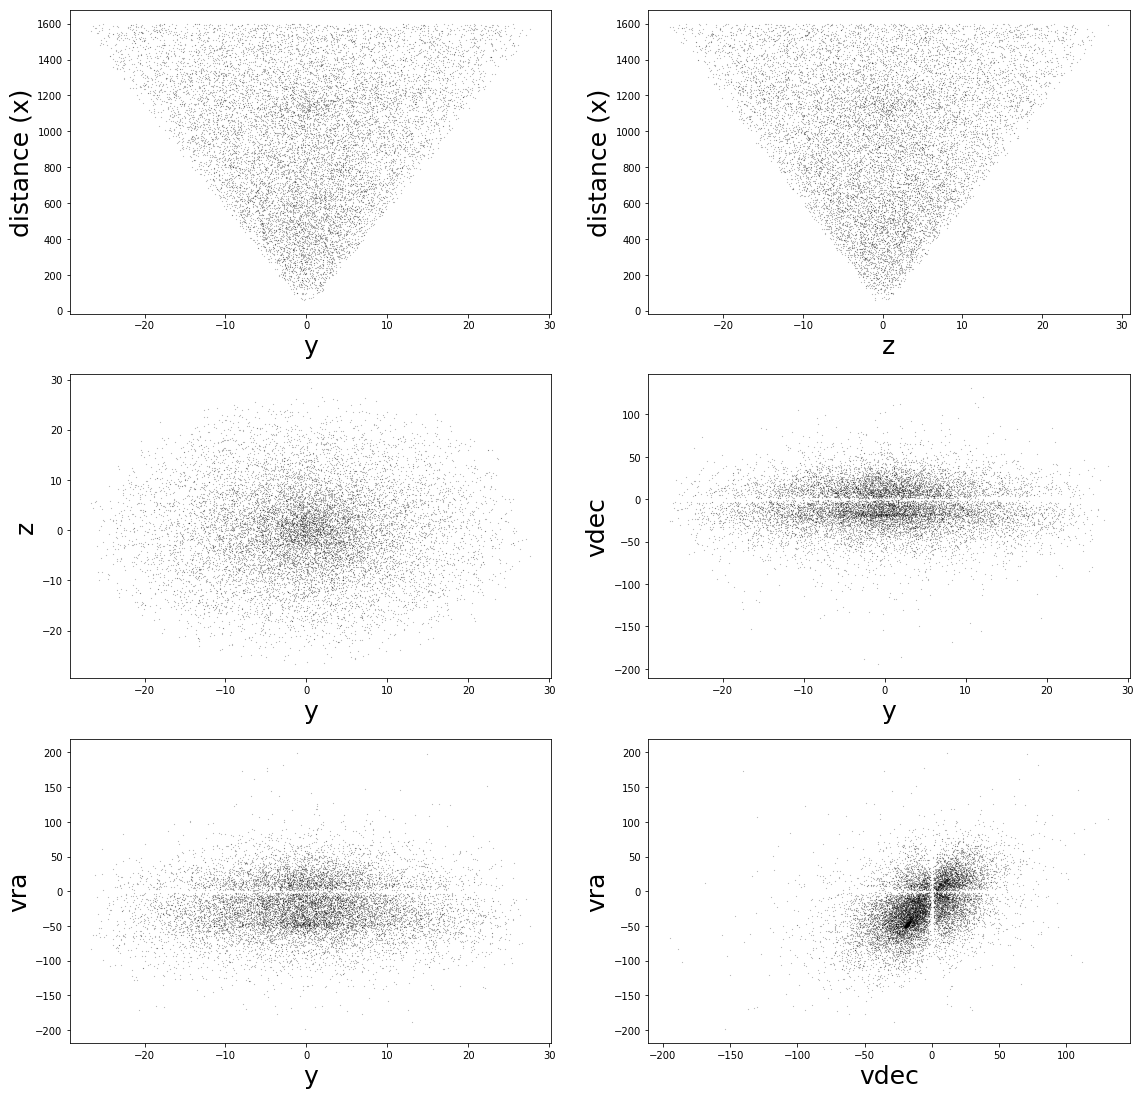

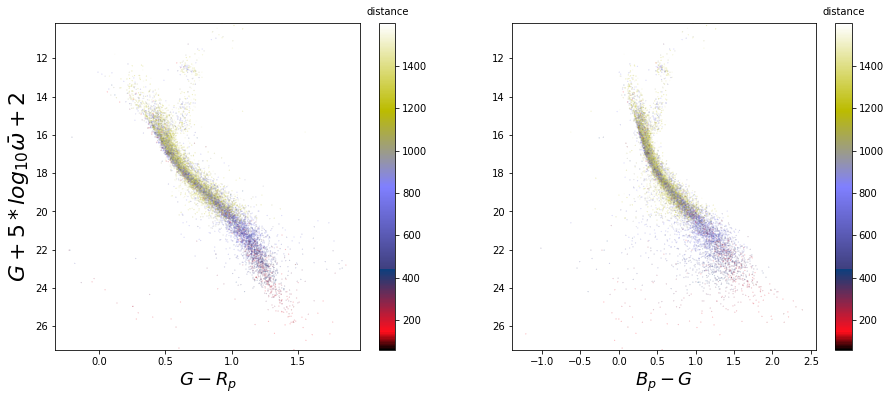

## 0, 352 stars, Dist : 1148.9, Max Dist : 328.4 and 26.3


In [58]:
for i, ilabel in enumerate(ilabel_):
    a = np.zeros(source.df.shape[0])
    a[ilabel] = 1
    ii = np.where(a==0)[0]
    gu.plot_information_cluster(source.dfcart[ii,:],size=0.01,cartesian=True)
    gu.plot_information_cluster(source.dfcart,size=0.01,cartesian=True)
    print("## %d, %d stars, Dist : %.1f, Max Dist : %.1f and %.1f"%(i,len(ilabel),np.mean(source.df[ilabel,0]),
    np.max(source.df[ilabel,0])-np.min(source.df[ilabel,0]),np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])))

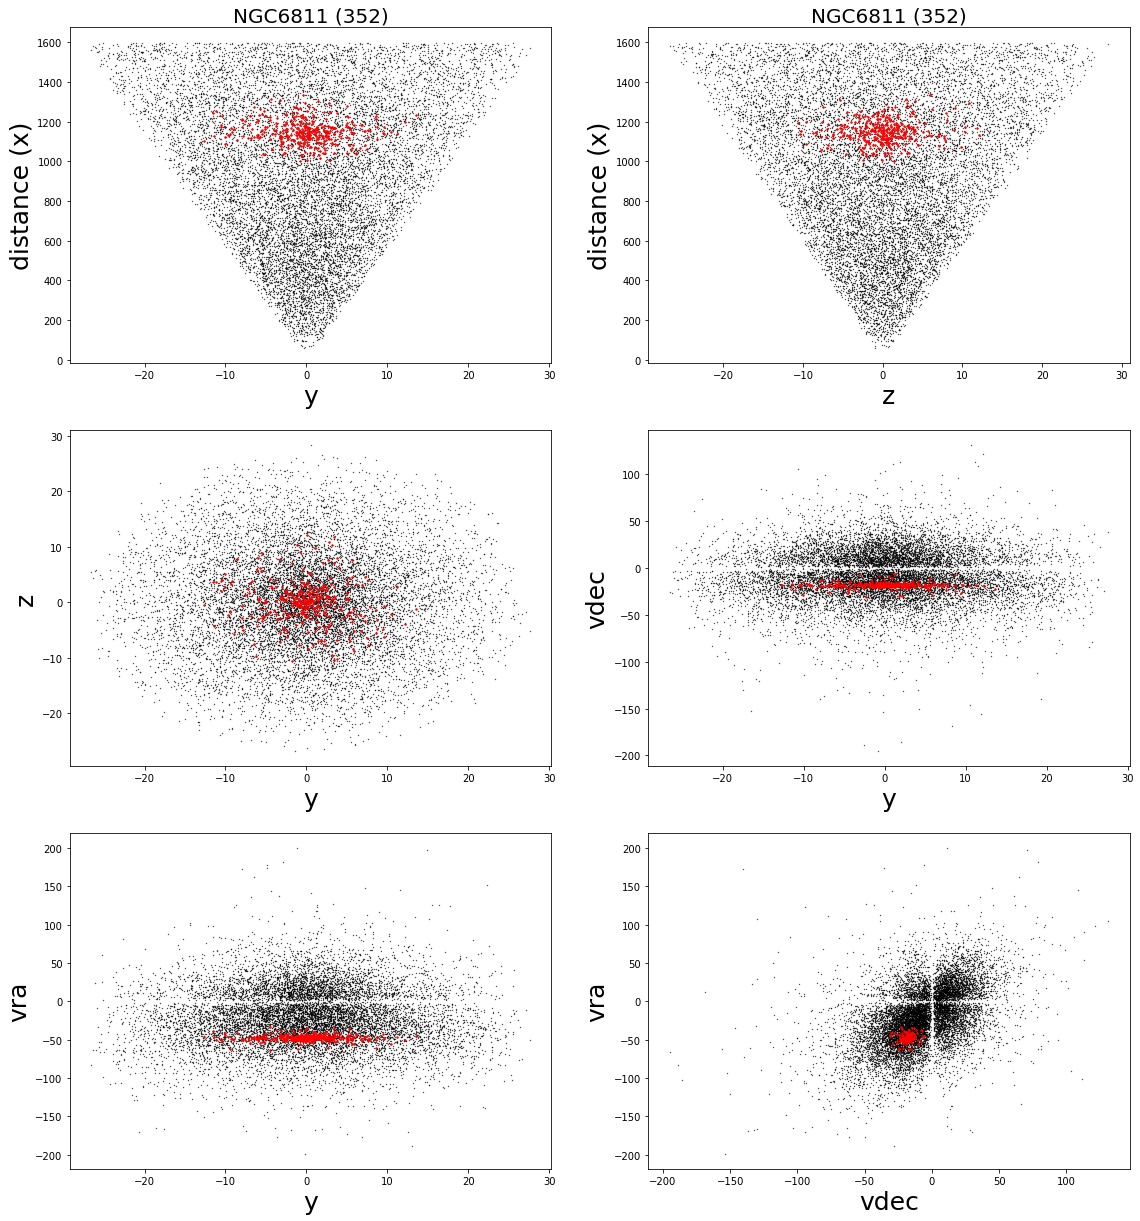

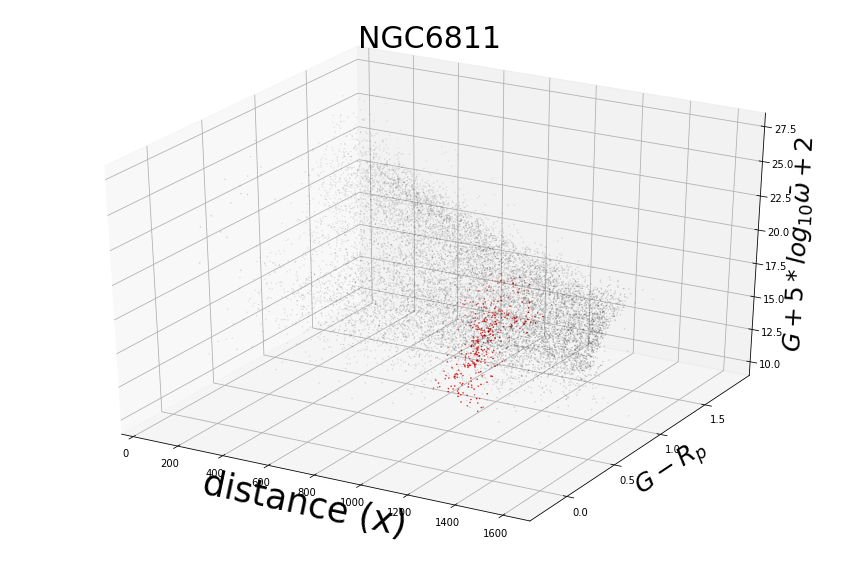

In [60]:
for ilabel in ilabel_ :
    #source.plot_information(0.1,False, HRD=False, ilabel=ilabel)
    source.plot_information(0.1,True, HRD=False, ilabel=ilabel)
    source.plot_3D(0.01,True,(0,6,5),ilabel=ilabel)

#### ------------------------------------------------------------------------
## Finding the best $eps$ and $min\_samples$

In [16]:
# #############################################################################
# Compute DBSCAN
ts = time.clock()
eps_ = [1.4,1.6,1.8,2.0,2.2,2.4,2.6]
min_samples_ = [10,15,20,25,30,40,50]
mat_nb_clusters = np.zeros((len(eps_),len(min_samples_)))
mat_max = np.zeros((len(eps_),len(min_samples_)))
for i in range(len(eps_)) :
    for j in range(len(min_samples_)) :
        db = DBSCAN(eps=eps_[i], min_samples=min_samples_[j]).fit(source.dfnorm)
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        mat_nb_clusters[i,j] = n_clusters_
        max_label = 0
        for n in range(n_clusters_) :
            ilabel = np.where(labels == n)[0]
            if len(ilabel) > max_label : max_label = len(ilabel)
        mat_max[i,j] = max_label
        #print("Ok pour eps "+str(eps_[i])+" et min_samples="+str(min_samples_[j]))
tf = time.clock() - ts
if tf//60 == 0 : string = "%.1fs"%(tf%60)
else : string = "%dmin %.1fs"%(tf//60,tf%60)
print("## Execution time : "+string)

## Execution time : 1min 21.7s


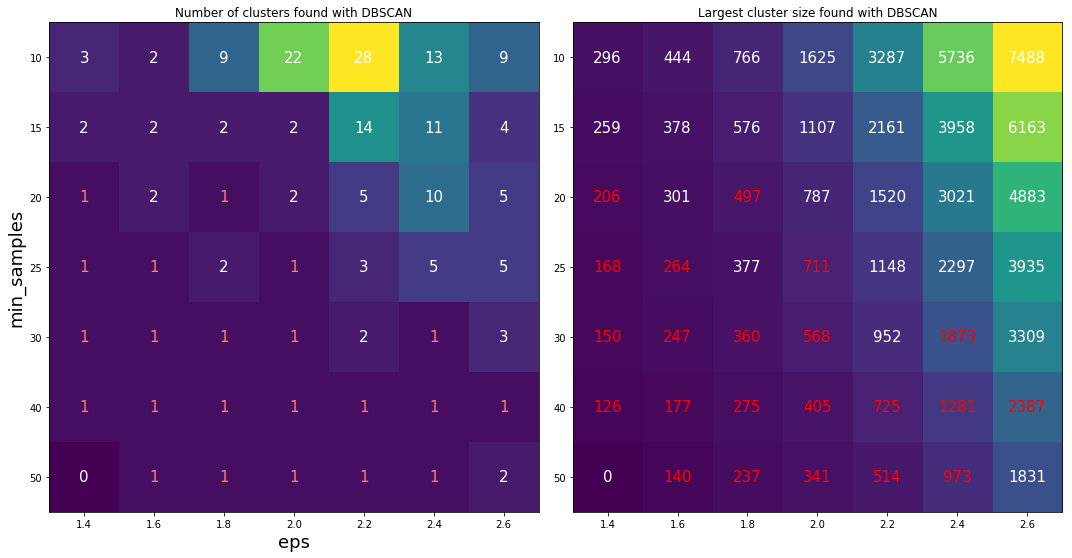

In [17]:
fig, (ax, ax2) = plt.subplots(1,2,figsize=(15,15))

im = ax.imshow(mat_nb_clusters.T)
ax.set_xticks(np.arange(len(eps_)))
ax.set_yticks(np.arange(len(min_samples_)))
ax.set_xticklabels(eps_)
ax.set_yticklabels(min_samples_)
# Loop over data dimensions and create text annotations.
for i in range(len(eps_)):
    for j in range(len(min_samples_)):
        if mat_nb_clusters[i, j] == 1 : color = "salmon"
        else : color = "w" 
        text = ax.text(i, j, '%d'%mat_nb_clusters[i, j],
                       ha="center", va="center", color=color, fontproperties='bold', fontsize=15)
ax.set_title("Number of clusters found with DBSCAN")
ax.set_xlabel("eps", fontsize = 18)
ax.set_ylabel("min_samples", fontsize = 18)
fig.tight_layout()

im = ax2.imshow(mat_max.T)
ax2.set_xticks(np.arange(len(eps_)))
ax2.set_yticks(np.arange(len(min_samples_)))
ax2.set_xticklabels(eps_)
ax2.set_yticklabels(min_samples_)
# Loop over data dimensions and create text annotations.
for i in range(len(eps_)):
    for j in range(len(min_samples_)):
        if mat_nb_clusters[i, j] == 1 : color = "r"
        else : color = "w" 
        text = ax2.text(i, j, '%d'%mat_max[i, j], ha="center", va="center", color=color, fontsize=15)
ax2.set_title("Largest cluster size found with DBSCAN")
ax.set_xlabel("eps", fontsize = 18)
ax.set_ylabel("min_samples", fontsize = 18)
fig.tight_layout()

plt.savefig('NGC6811_.png')
plt.show()